# Introduction

Our starting point was a Kaggle competition “Riid Answer Correctness Prediction”. Therefor we used the EdNet data set to predict a students response correctness to newly encountered multiple-choice questions. 

## EdNet data set

The EdNet data set was collected by a multi-platform AI tutoring service with 784,309 students in South Korea. The EdNet data set is composed of a total of 131,441,538 interactions, which have been collected over a period of two years. Each student has generated an average of 441.20 interactions using the tutoring service. Possible interactions are answering questions or watching lectures. 

The data set it is divided in four different data sets, KT1, KT2, KT3 and KT4. KT1 only consists of question-response pairs. The questions come in bundles, which belong to the same material and the students have to respond to all questions in a bundle to complete that bundle. In the next data sets the full behavior of the student using the platform is recorded, in KT2 all actions related to the question solving activities is recorded, such as switching between answers before submitting the final choice. In KT3 the possible actions are extended, for example reading materials or watching lectures. In KT4 all collected actions are included.

## Data sets 

We used the following data provided by Kaggle. The lectures.csv, questions.csv and train.csv. The lectures.csv contains four columns, lecture_id, tag, part and type_of. 
Explanation for columns:
-  lecture_id: foreign key for the train content_id column, if the content type is lecture
- tag: tag codes for the lecture
- part: top level category code for the lecture
- type_of: description of the purpose of the lecture

The question.csv contains five columns, question_id, bundle_id, correct_answer, part and tags. 
Explanation for columns:
- question_id: foreign key for the train content_id column, if the content type is question
- bundle_id: code for which questions belong together
- correct_answer: answer to the question
- part: section of the TOEIC test
- tags: tag codes for the question

The train.csv contains ten columns, row_id, timestamp, user_id, content_id, content_type, task_container_id, user_answer, answered_correctly, prior_question_elapsed_time, prior_question_had_explanation. 
Explanation for columns:
-  row_id: ID code for the row
- timestamp: time in milliseconds from their first action
- user_id: ID code for the user
- content_id: ID code for the user interaction
- content_type: 0 if the event was a question, 1 if the event was a lecture
- task_container_id: ID code for the batch of questions or lectures
- user_answer: the users answer to a question, -1 for lectures
- answered_correctly: if the user responded correctly, -1 for lectures
- prior_question_elapsed_time: the average time in milliseconds a user needed to answer a question in the previous bundle
- prior_question_had_explanation: whether or not the user saw an explanation and the correct responses after answering he previous question bundle

## Libraries
### Pandas
We decided to work with the library pandas because it is useful for data manipulation and data analysis. It contains many versatile features and supports data imports from various file formats. Furthermore it provides a variety of analytical functions to plot and describe the data.
### Datatable
Since the train.csv file is to large to load into the 16 GB RAM via the standard library pandas, we had to bypass these hardware limitations. We used the library datatable to load train.csv and start preprocessing and filtering the data to a more manageable size for a pandas dataframe. One of the short commings of datatable is that it is still undergoing active development, therefore the functions that are available are only a subset of the functions that are offered by te pandas library. 

Source:
- https://arxiv.org/pdf/1912.03072v3.pdf 
- https://www.kaggle.com/berobillard/riid-shared-modeling
- https://github.com/h2oai/datatable

In [1]:
import datatable as dt
import pandas as pd
from datatable import (dt, f, by, ifelse, update, sort,
                       count, min, max, mean, sum, count, rowsum, join)

### Loading the dataset

With the _datatable_ function fread() we load the _train.csv_ file

In [2]:
df = dt.fread("raw_data/train.csv")

After that we can load the files _lectures.csv_ and _questions.csv_ with the _pandas_ function read_csv(). Note that it is not possible to apply _pandas_ functions to _datatable_ dataframes or the athor way round.

In [3]:
df_lectures = pd.read_csv('raw_data/lectures.csv')
df_questions = pd.read_csv('raw_data/questions.csv')

To get a first look into the data we count how many different user_ids there are in the _train.csv_ and save the results in df_num_entries.

In [4]:
df_num_entries = df[:, count(f.row_id), by('user_id')]

Data set has 393656 unique user_ids

As mentioned above the libray _datatable_ lacks many of the features that pandas offers. We get around this issue by slicing the data into new datasets that we are able to handle in pandas. 

In [5]:
df_num_entries_pd = df_num_entries.to_pandas()

In the following graphic we can see that the majority of the users only have a really limited amount of interactions. Over 300,000 users have nearly no interactions. The most active users have up to 3,000 interactions. But what you can’t see in this graphic is that there is at least one person with 17,500 interactions. 

array([[<AxesSubplot:title={'center':'row_id'}>]], dtype=object)

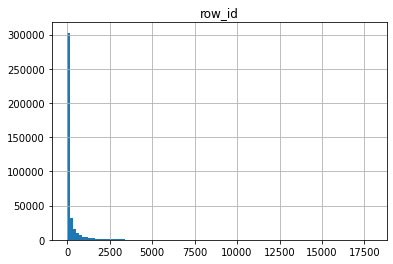

In [6]:
df_num_entries_pd[['row_id']].hist(bins=100)

As we saw in the preceding figure we can not consider all users, but we have to limit the considered users to the ones which are comparable to each other so we represent the interactions of the users in the following box plot. Here you can see that the most outliers seem to be above 300 interactions. 

<AxesSubplot:>

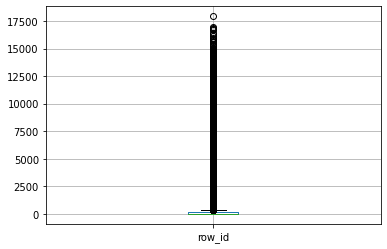

In [7]:
df_num_entries_pd[['row_id']].boxplot()

Now we check how high the percentage of users with more then 100 actions is. The amount of users with more then 100 interactions are 31.77%, which is a significant amount.

In [8]:
len(df_num_entries_pd[df_num_entries_pd['row_id'] >= 100]) / len(df_num_entries_pd)

0.3177037819822383

Now we check if he data set has a significant amount of users with more then 1000 actions. But for 1000 interactions we only get 5.97% of users, which is a significant decline.

In [9]:
len(df_num_entries_pd[df_num_entries_pd['row_id'] >= 1000]) / len(df_num_entries_pd)

0.05971711341882253

Following we remove the outliers as we saw in the box plot above. We only keep values which are within 1.5 * interquantile range of Q1 and Q3, the values which don’t fall into that range are the outliers and are cut from our user_id. We still end up with 333791 users after removing the outliers.

In [10]:
import scipy.stats as stats
df_tmp = df_num_entries_pd.set_index('user_id')

#find Q1, Q3, and interquartile range for each column
Q1 = df_tmp.quantile(q=.25)
Q3 = df_tmp.quantile(q=.75)
IQR = df_tmp.apply(stats.iqr)

#only keep rows in dataframe that have values within 1.5*IQR of Q1 and Q3
data_clean = df_tmp[~((df_tmp < (Q1-1.5*IQR)) | (df_tmp > (Q3+1.5*IQR))).any(axis=1)]

#find how many rows are left in the dataframe 
data_clean.shape

(333791, 1)

Through this code we removed 15.21% of the users which we classified as outliers and consequently as not relevant for our purposes.

In [11]:
1 - len(data_clean) / len(df_num_entries_pd)

0.15207439998374217

The maximum number of interactions a user has in the data we use is now 347, compared to 17917 before the removal of the outliers.

In [12]:
print(df_num_entries_pd.row_id.max(), '\n',data_clean.row_id.max())

17917 
 347


Now we create a new box plot which shows the distribution of interactions of the remaining users. The highest amount of interactions is 347 and the average is still below 50 interactions.

<AxesSubplot:>

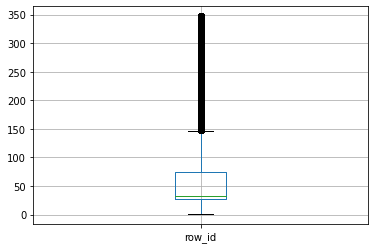

In [13]:
data_clean[['row_id']].boxplot()

Since we expect users with less than 100 entries to have a lower explanatory value for our prediction, we remove these users and create another box plot with all users with an amount of interactions between 100 and 347.

<AxesSubplot:>

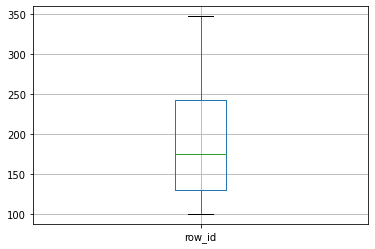

In [14]:
df_without_outliers = data_clean[data_clean['row_id'] >= 100]
df_without_outliers.boxplot()

Through this methods we keep 16.56% of the original users. With these number we will continue to work from here on.

In [15]:
len(df_without_outliers) / len(df_num_entries_pd)

0.16562938199849614

select from original train the users we are interested in and transform df to pandas Dataframe

In [16]:
df_without_outliers

,row_id
user_id,
5382,128
8623,112
12741,271
44331,294
165081,122
...,...
2147375580,100
2147402806,177
2147469944,276


In [17]:
df_without_outliers

,row_id
user_id,
5382,128
8623,112
12741,271
44331,294
165081,122
...,...
2147375580,100
2147402806,177
2147469944,276


In the dataset df_without_outliers we have now selected the user_ids we want to use for constructing our final dataset. The column _row\_id_ is no longer necessary. But since we are using _datatable_ we cannot just simply do an inner join of the dataframe _df_without_outliers_ and the dataframe _df_. Although a join function is present in _datatable_ it only offers the ability to do left joins and the keys on which to join on have to be unique. To get around this limitation we convert the columns _user\_id_ and _row\_id_ from df to a pandas dataframe. By only selecting these two columns we make sure, it will fit int our RAM. Next join the newly constructed dataframe on _user\_id_. This operation yields us a dataframe which consists of all the row_ids we want to select from the original dataframe. After converting this dataframe back into a _datatable_ dataframe we can left join on this dataframe the original dataframe. With _df\_train\_without\_outliers_ we have constructed a dataframe which contains all the user interactions from the original dataframe from the user we selected with the statistical outlier removal

In [18]:
df_without_outliers = df_without_outliers.reset_index()
df_user_row = df[:, ["row_id", "user_id"]].to_pandas()
df_without_outliers = pd.merge(df_user_row, df_without_outliers[['user_id']], on='user_id')
df_1 = dt.Frame(df_without_outliers)
df.key = 'row_id'
df_train_without_outliers = df_1[:, :, join(df)]

Now we can finally convert the dataframe _df\_train\_without\_outliers_ into a pandas dataframe. This dataframe now consists of 12.440.846 user interactions.

In [19]:
df_train_without_outliers = df_train_without_outliers.to_pandas()
df_train_without_outliers.shape

(12440846, 11)

In [20]:
df_train_without_outliers.shape

(12440846, 11)

# 1. Teil Ende

In [21]:
#df_train_without_outliers.to_pickle('df_train_.pckl')

In [22]:
#df_train_without_outliers.to_pickle('df_train_without_outliers.pckl')

# 2. Teil Einleitung
feature engineering beschreiben Egon

Egon Ablauf beschreiben

In [23]:
df = pd.merge(df_train_without_outliers, df_questions, left_on='content_id', right_on='question_id', how='left')

In [24]:
df = pd.merge(df, df_lectures, left_on='content_id', right_on='lecture_id', how='left')

In [25]:
df_lectures.type_of.unique()

array(['concept', 'solving question', 'intention', 'starter'],
      dtype=object)

In [26]:
df_lectures.columns

Index(['lecture_id', 'tag', 'part', 'type_of'], dtype='object')

ToDos:
    1. feature engineering
    2. impute missing data
    3. prepare data format and shape of dataframe
    4. split into train/test (chronological or random?)

Prepare features for df_questions

In [27]:
df_question_eval = df[(df.question_id.notnull()) & (df.answered_correctly >= 0)][['answered_correctly', 'question_id']].groupby('question_id').agg(['count', 'sum'])
df_question_eval['correctness_ratio'] = df_question_eval[('answered_correctly', 'sum')] / df_question_eval[('answered_correctly', 'count')]

In the following graphic we see the correctness_ratio of correctly answered questions. Which means how often are questions answered  correctly. The most questions are more often answered correctly, than falsely. Only a small amount of questions is answered mostly wrong. Correctness_ratio seems to have a good correlation with question_id so we decided it is a good feature for our purposes. 

array([[<AxesSubplot:title={'center':"('correctness_ratio', '')"}>]],
      dtype=object)

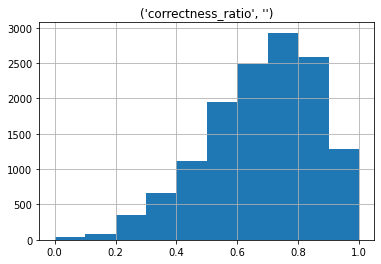

In [28]:
df_question_eval[['correctness_ratio']].hist()

df_questions tag in one hot encoding 

In [29]:
df_questions.head()

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38


In [30]:
question_tag_list = list()
for i, row in df_questions[df_questions.tags.notnull()].iterrows():
    for tag in row['tags'].split():
        if tag != ' ':
            question_tag_list.append([('question_' + tag), row['question_id']])

df_question_tag = pd.DataFrame(question_tag_list, columns=['tags', 'question_id'])

df_question_tag = pd.merge(df_question_tag, pd.get_dummies(df_question_tag.tags), left_index=True, right_index=True)
del df_question_tag['tags']

df_question_tag = df_question_tag.groupby('question_id').sum()

In [31]:
df_question_tag

,question_0,question_1,question_10,question_100,question_101,question_102,question_103,question_104,question_105,question_106,...,question_90,question_91,question_92,question_93,question_94,question_95,question_96,question_97,question_98,question_99
question_id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13518,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13519,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13520,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
df_question_eval.columns = df_question_eval.columns.get_level_values(0)

In [33]:
df_question_ohe = pd.merge(df_question_eval[['correctness_ratio']], df_question_tag, left_index=True, right_index=True)

In [34]:
df_question_ohe

,correctness_ratio,question_0,question_1,question_10,question_100,question_101,question_102,question_103,question_104,question_105,...,question_90,question_91,question_92,question_93,question_94,question_95,question_96,question_97,question_98,question_99
question_id,,,,,,,,,,,,,,,,,,,,,
0,0.917222,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.850674,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.534265,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0.758056,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.606128,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13518,0.750000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13519,0.508108,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13520,0.628931,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We created the correlation matrix for all possible question tags. 
In the following graphic we can see the ten highest correlating question tags and the ten lowest correlating question tags with the correctness ratio of the questions flagged with the tags. For example we can see that questions with the tag 131 are frequently answered correctly or that questions that don’t have the tag 131 are often answered wrong. The other way around it is with question with the tag 73.

<AxesSubplot:title={'center':'10 highest/lowest correlating tags with correctness ratio of question'}, xlabel='tag', ylabel='correlation coefficient'>

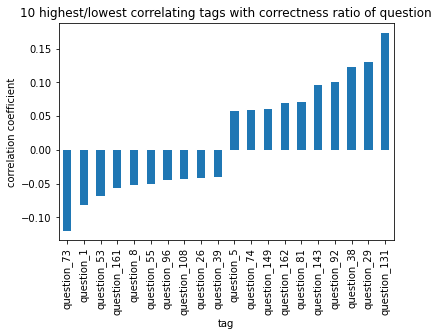

In [35]:
df_question_ohe_corr = df_question_ohe.corr()
df_question_ohe_corr = df_question_ohe_corr.sort_values('correctness_ratio')
df_question_ohe_corr['correctness_ratio'][0:10].append(df_question_ohe_corr['correctness_ratio'][-11:-1]).plot.bar(title='10 highest/lowest correlating tags with correctness ratio of question', xlabel='tag', ylabel='correlation coefficient')

Construct dataset for classifier that works on non timeseries data

In [36]:
df_lectures_ohe = pd.get_dummies(df_lectures.tag, prefix='lecture')
df_lectures_ohe.index = df_lectures.lecture_id
df_lectures_ohe

,lecture_0,lecture_1,lecture_2,lecture_4,lecture_5,lecture_6,lecture_7,lecture_8,lecture_9,lecture_12,...,lecture_176,lecture_177,lecture_178,lecture_179,lecture_180,lecture_181,lecture_182,lecture_183,lecture_184,lecture_187
lecture_id,,,,,,,,,,,,,,,,,,,,,
89,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
185,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
192,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
317,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32535,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
32570,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32604,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
df_question_ohe

,correctness_ratio,question_0,question_1,question_10,question_100,question_101,question_102,question_103,question_104,question_105,...,question_90,question_91,question_92,question_93,question_94,question_95,question_96,question_97,question_98,question_99
question_id,,,,,,,,,,,,,,,,,,,,,
0,0.917222,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.850674,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.534265,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0.758056,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.606128,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13518,0.750000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13519,0.508108,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13520,0.628931,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [44]:

pca = PCA()
pca.fit(df_question_ohe)
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)


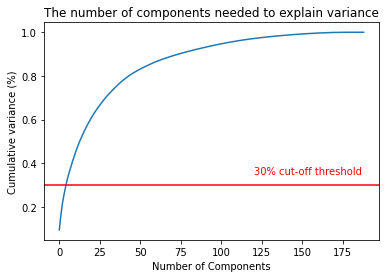

In [69]:
import matplotlib.pyplot as plt
plt.plot(exp_var_cumul)

plt.xlabel('Number of Components')
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.30, color='r', linestyle='-')
plt.text(120, 0.35, '30% cut-off threshold', color = 'red', fontsize=10)

plt.show()

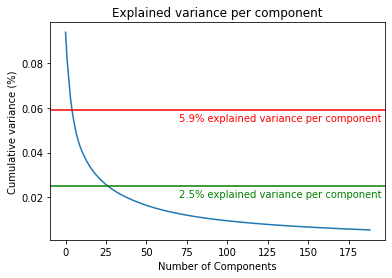

In [88]:
exp_var_cumul_ratio = [exp_var/(i+1) for i, exp_var in enumerate(exp_var_cumul)]

plt.plot(exp_var_cumul_ratio)

plt.xlabel('Number of Components')
plt.ylabel('Cumulative variance (%)')
plt.title('Explained variance per component')

plt.axhline(y=0.059, color='r', linestyle='-')
plt.text(70, 0.054, '5.9% explained variance per component', color = 'red', fontsize=10)

plt.axhline(y=0.025, color='g', linestyle='-')
plt.text(70, 0.02, '2.5% explained variance per component', color = 'green', fontsize=10)

plt.show()

In [38]:
import numpy as np
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
pca.fit(df_question_ohe)
df_question_ohe_pca = pd.DataFrame(pca.transform(df_question_ohe), index=df_question_ohe.index)

In [39]:
df_question_ohe_pca

,0,1,2,3,4
question_id,,,,,
0,0.301050,0.716078,-0.103408,-0.366440,0.601694
1,0.193132,-0.250129,-0.672306,0.340624,-0.058555
2,0.293721,-0.607122,0.399174,-0.369630,0.561088
3,0.144565,0.249565,0.620300,0.584290,0.560894
4,0.273704,0.711278,-0.115578,-0.371720,0.583250
...,...,...,...,...,...
13518,-0.311751,-0.004249,-0.000819,0.003979,-0.105503
13519,-0.416302,-0.012926,-0.011052,0.006367,-0.279491
13520,-0.385120,-0.009958,-0.007681,0.005133,-0.204454


In [40]:
df_new = pd.merge(df[['question_id', 'answered_correctly']], df_question_ohe_pca, left_on='question_id', right_index=True, how='inner')

In [41]:
del df_new['question_id']
df_new

,answered_correctly,0,1,2,3,4
0,1,-0.318171,-0.011274,-0.010684,0.002570,-0.101244
2301,1,-0.318171,-0.011274,-0.010684,0.002570,-0.101244
6064,0,-0.318171,-0.011274,-0.010684,0.002570,-0.101244
6073,1,-0.318171,-0.011274,-0.010684,0.002570,-0.101244
27449,0,-0.318171,-0.011274,-0.010684,0.002570,-0.101244
...,...,...,...,...,...,...
12298600,1,-0.378915,-0.009407,0.025431,-0.080619,1.311921
12298601,1,-0.378915,-0.009407,0.025431,-0.080619,1.311921
12298602,1,-0.348462,-0.008393,0.025126,-0.075108,1.196546
12298603,0,-0.484976,-0.033335,-0.005637,-0.087394,1.355613


In [42]:
df_new[df_new.answered_correctly != -1].corr()

,answered_correctly,0,1,2,3,4
answered_correctly,1.000000,0.093094,0.019894,0.009828,-0.023140,0.056124
0,0.093094,1.000000,-0.011203,0.070875,-0.183648,0.068602
1,0.019894,-0.011203,1.000000,-0.081609,-0.035792,-0.007450
2,0.009828,0.070875,-0.081609,1.000000,-0.038297,0.021880
3,-0.023140,-0.183648,-0.035792,-0.038297,1.000000,0.019865
4,0.056124,0.068602,-0.007450,0.021880,0.019865,1.000000


In [43]:
df.to_parquet('user_interactions_with_questions_lectures_merged.parquet')
df_question_ohe.to_parquet('question_ohe.parquet')
df_lectures_ohe.to_parquet('lectures_ohe.parquet')